<a href="https://colab.research.google.com/github/T-Cent/culling/blob/main/culling_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pytorchtools

In [ ]:
!python -c "import pytorchtools as pt; print(dir(pt))"

['__author__', '__builtins__', '__cached__', '__doc__', '__email__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '__version__']


In [ ]:
!pip install onnxruntime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 41.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 11.3 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
# from pytorchtools import EarlyStopping
import matplotlib.pyplot as plt
import time
import os
from tempfile import TemporaryDirectory
from PIL import Image
import imageio
import imgaug as ia
from imgaug import augmenters as iaa
import random
import glob
import pandas as pd
import requests
# import onnxruntime as ort

cudnn.benchmark = True
plt.ion()
%matplotlib inline

#Setting up images

using augmetation on images found in the unsplash dataset and saving them in their respective folder

In [ ]:
!wget https://unsplash.com/data/lite/latest

--2024-05-25 14:55:05--  https://unsplash.com/data/lite/latest
Resolving unsplash.com (unsplash.com)... 151.101.1.181, 151.101.193.181, 151.101.65.181, ...
Connecting to unsplash.com (unsplash.com)|151.101.1.181|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://unsplash-datasets.s3.amazonaws.com/lite/latest/unsplash-research-dataset-lite-latest.zip [following]
--2024-05-25 14:55:06--  https://unsplash-datasets.s3.amazonaws.com/lite/latest/unsplash-research-dataset-lite-latest.zip
Resolving unsplash-datasets.s3.amazonaws.com (unsplash-datasets.s3.amazonaws.com)... 52.216.152.28, 16.182.103.145, 3.5.28.166, ...
Connecting to unsplash-datasets.s3.amazonaws.com (unsplash-datasets.s3.amazonaws.com)|52.216.152.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 494063166 (471M) [application/zip]
Saving to: ‘latest’

latest                0%[                    ] 109.49K   170KB/s               ^C


In [ ]:
!unzip "/content/latest" -d "/content/drive/MyDrive/Culling/Unsplash_Dataset"

Archive:  /content/latest
  inflating: /content/drive/MyDrive/Culling/Unsplash_Dataset/collections.tsv000  
  inflating: /content/drive/MyDrive/Culling/Unsplash_Dataset/__MACOSX/._collections.tsv000  
  inflating: /content/drive/MyDrive/Culling/Unsplash_Dataset/colors.tsv000  
  inflating: /content/drive/MyDrive/Culling/Unsplash_Dataset/__MACOSX/._colors.tsv000  
  inflating: /content/drive/MyDrive/Culling/Unsplash_Dataset/conversions.tsv000  
  inflating: /content/drive/MyDrive/Culling/Unsplash_Dataset/__MACOSX/._conversions.tsv000  
  inflating: /content/drive/MyDrive/Culling/Unsplash_Dataset/DOCS.md  
  inflating: /content/drive/MyDrive/Culling/Unsplash_Dataset/keywords.tsv000  
  inflating: /content/drive/MyDrive/Culling/Unsplash_Dataset/__MACOSX/._keywords.tsv000  
  inflating: /content/drive/MyDrive/Culling/Unsplash_Dataset/photos.tsv000  
  inflating: /content/drive/MyDrive/Culling/Unsplash_Dataset/__MACOSX/._photos.tsv000  
  inflating: /content/drive/MyDrive/Culling/Unsplash_D

In [ ]:
path = '/content/drive/MyDrive/Culling/Unsplash_Dataset/'
documents = ['photos', 'keywords', 'collections', 'conversions', 'colors']
unsplash_dataset = {}

for doc in documents:
  files = glob.glob(path + doc + ".tsv*")

  subsets = []
  for filename in files:
    df = pd.read_csv(filename, sep='\t', header=0)
    subsets.append(df)

  unsplash_dataset[doc] = pd.concat(subsets, axis=0, ignore_index=True)

In [ ]:
unsplash_dataset["photos"]["photo_image_url"].head()

0    https://images.unsplash.com/uploads/1413387620...
1    https://images.unsplash.com/reserve/jEs6K0y1Sb...
2    https://images.unsplash.com/uploads/1412192004...
3    https://images.unsplash.com/reserve/ijl3tATFRp...
4    https://images.unsplash.com/reserve/6vaWXsQuSW...
Name: photo_image_url, dtype: object

In [ ]:
for i, url in enumerate(unsplash_dataset["photos"]["photo_image_url"]):
  try:
    image = Image.open(requests.get(url, stream=True).raw)
    image.save("/content/drive/MyDrive/Culling/Unsplash_Dataset/Unsplash_Images/unsplash" + str(i) + ".jpg")
  except:
    continue

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (121554000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [ ]:
num_img = len(os.listdir("/content/drive/MyDrive/Culling/Unsplash_Dataset/Unsplash_Images"))
num_img

1756

In [ ]:
data_dir = "/content/drive/MyDrive/Culling/Unsplash_Dataset/Unsplash_Images/"
filenames = [data_dir + f for f in os.listdir("/content/drive/MyDrive/Culling/Unsplash_Dataset/Unsplash_Images")]
for_training = random.sample(filenames, k=int(num_img*0.8)) #80-20 split
for_testing = [f for f in filenames if f not in for_training]
num_training, num_testing = len(for_training), len(for_testing)
num_training, num_testing

(1404, 352)

In [ ]:
training_noisy = for_training[:600]
training_blurred = for_training[:600]
training_exposed = for_training[:600]
training_good = for_training[:600]

testing_noisy = for_testing[:60]
testing_blurred = for_testing[:60]
testing_exposed = for_testing[:60]
testing_good = for_testing[:60]

# training_noisy = random.sample(for_training, 600)
# training_blurred = random.sample(for_training, 600)
# training_exposed = random.sample(for_training, 600)
# training_good = random.sample(for_training, 600)

# testing_noisy = random.sample(for_testing, 80)
# testing_blurred = random.sample(for_testing, 80)
# testing_exposed = random.sample(for_testing, 80)
# testing_good = random.sample(for_testing, 80)

In [ ]:
transform = iaa.Sequential([
    iaa.Resize((1024, 1024)),
    iaa.Sometimes(0.2, iaa.Fliplr(1)),
    iaa.Sometimes(0.1, iaa.Flipud(1)),
    iaa.Grayscale(alpha=1)
])

blur_sequence = iaa.Sequential([
    iaa.Sometimes(0.3, then_list=iaa.MotionBlur(k=(10, 15), angle=[-180, 180]), else_list=iaa.GaussianBlur(sigma=(2, 5)))
])

noise_sequence = iaa.Sequential([
    iaa.AddElementwise((-40, 40)),
    iaa.Sometimes(0.9, then_list=iaa.AdditiveGaussianNoise(scale=(10, 20)), else_list=iaa.AdditiveGaussianNoise(scale=(10, 20), per_channel=True))
], random_order=True)

exposure_sequence = iaa.Sequential([
    iaa.Sometimes(0.5, then_list=iaa.Multiply((0.2, 0.5)), else_list=iaa.Multiply((1.6, 1.9)))
])

<ipython-input-6-754a74cb0cb3>:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  test = imageio.imread(training_blurred[5])


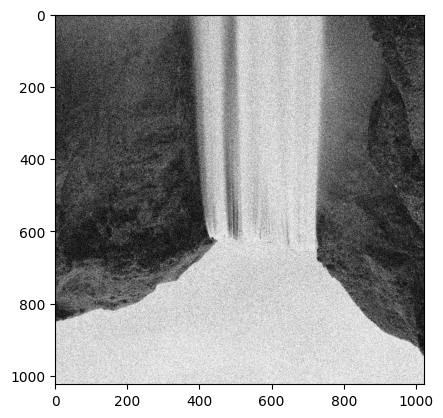

In [ ]:
test = imageio.imread(training_blurred[5])
test = noise_sequence(image=transform(image=test))
# test = blur_sequence(image=test)
# test = exposure_sequence(image=test)
test = noise_sequence(image=test)
# gray = iaa.Grayscale(alpha=1)
# test = gray(image=test)
plt.imshow(test)

In [ ]:
loc = "/content/drive/MyDrive/Culling/dataset_v7/"

training = [imageio.imread(f) for f in for_training]
testing = [imageio.imread(f) for f in for_testing]

training_noisy = [imageio.imwrite(loc+"train/noisy/" + str(i) + ".jpg", noise_sequence(image=transform(image=f))) for i, f in enumerate(for_training)]
training_blurred = [imageio.imwrite(loc+"train/blurred/" + str(i) + ".jpg", blur_sequence(image=transform(image=f))) for i, f in enumerate(for_training)]
training_exposed = [imageio.imwrite(loc+"train/exposed/" + str(i) + ".jpg", exposure_sequence(image=transform(image=f))) for i, f in enumerate(for_training)]
training_good = [imageio.imwrite(loc+"train/good/" + str(i) + ".jpg", image=transform(image=f)) for i, f in enumerate(for_training)]

testing_noisy = [imageio.imwrite(loc+"test/noisy/" + str(i) + ".jpg", noise_sequence(image=transform(image=f))) for i, f in enumerate(for_testing)]
testing_blurred = [imageio.imwrite(loc+"test/blurred/" + str(i) + ".jpg", blur_sequence(image=transform(image=f))) for i, f in enumerate(for_testing)]
testing_exposed = [imageio.imwrite(loc+"test/exposed/" + str(i) + ".jpg", exposure_sequence(image=transform(image=f))) for i, f in enumerate(for_testing)]
testing_good = [imageio.imwrite(loc+"test/good/" + str(i) + ".jpg", image=transform(image=f)) for i, f in enumerate(for_testing)]

# testing_noisy = [noise_sequence(image=transform(image=f)) for f in for_testing]
# testing_blurred = [blur_sequence(image=transform(image=f)) for f in for_testing]
# testing_exposed = [exposure_sequence(image=transform(image=f)) for f in for_testing]
# testing_good = [transform(image=f) for f in for_testing]

<ipython-input-7-2181cdf88584>:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  training = [imageio.imread(f) for f in for_training]


In [ ]:
# # train = [training_noisy, training_blurred, training_exposed, training_good]
# # test = [testing_noisy, testing_blurred, testing_exposed, testing_good]

# for i, im in enumerate(training_noisy):
#   imageio.imwrite(loc+"train/noisy/" + str(i) + ".jpg", im)
# for i, im in enumerate(training_blurred):
#   imageio.imwrite("/content/drive/MyDrive/Culling/dataset_v7/train/blurred/" + str(i) + ".jpg", im)
# for i, im in enumerate(training_exposed):
#   imageio.imwrite("/content/drive/MyDrive/Culling/dataset_v7/train/exposed/" + str(i) + ".jpg", im)
# for i, im in enumerate(training_good):
#   imageio.imwrite("/content/drive/MyDrive/Culling/dataset_v7/train/good/" + str(i) + ".jpg", im)

# for i, im in enumerate(testing_noisy):
#   imageio.imwrite("/content/drive/MyDrive/Culling/dataset_v7/test/noisy/" + str(i) + ".jpg", im)
# for i, im in enumerate(testing_blurred):
#   imageio.imwrite("/content/drive/MyDrive/Culling/dataset_v7/test/blurred/" + str(i) + ".jpg", im)
# for i, im in enumerate(testing_exposed):
#   imageio.imwrite("/content/drive/MyDrive/Culling/dataset_v7/test/exposed/" + str(i) + ".jpg", im)
# for i, im in enumerate(testing_good):
#   imageio.imwrite("/content/drive/MyDrive/Culling/dataset_v7/test/good/" + str(i) + ".jpg", im)

In [ ]:
len(training_noisy)

In [ ]:
augmentors = {
    "blurry": blur_sequence,
    "noisy": noise_sequence,
    "exposed": exposure_sequence
}

save_dir = "/content/drive/MyDrive/Culling/dataset_v5/"
gray = iaa.Grayscale(alpha=1)

def save_images(image: str, aug: str = "good", im_type: str = "train", suffix: int = 0):
  x = save_dir + im_type + "/" + aug + "/"
  img = imageio.imread(image)
  if aug != "good":
    augmentor = augmentors[aug]
    img = augmentor(image=img)
  img = gray(image=img)
  imageio.imwrite(x+aug+str(suffix)+"_v6.jpg", img)

saving and manipulating all images

In [ ]:
len(training_noisy)

500

In [ ]:
# for i, f in enumerate(training_blurred):
#   if i > 100:
#     break
#   save_images(f, "blurry", "train", i)
# for i, f in enumerate(training_noisy):
#   if i > 100:
#     break
#   save_images(f, "noisy", "train", i)
# for i, f in enumerate(training_exposed):
#   if i > 100:
#     break
#   save_images(f, "exposed", "train", i)
# for i, f in enumerate(training_good):
#   if i > 100:
#     break
#   save_images(f, "good", "train", i)

# for i, f in enumerate(testing_blurred):
#   if i > 200:
#     break
#   save_images(f, "blurry", "test", i)
# for i, f in enumerate(testing_noisy):
#   if i > 200:
#     break
#   save_images(f, "noisy", "test", i)
# for i, f in enumerate(testing_exposed):
#   if i > 200:
#     break
#   save_images(f, "exposed", "test", i)
# for i, f in enumerate(testing_good):
#   if i > 200:
#     break
#   save_images(f, "good", "test", i)

<ipython-input-19-1403dc450d55>:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image)


#Copying Learning!

training a model via transfer learning, following the tutorial on the pytorch website - https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(512),
        # transforms.RandomResizedCrop(224),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(512),
        # transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = "/content/drive/MyDrive/Culling/dataset_v7"

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=128, shuffle=True)
              for x in ['train', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}

class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class_names, device

(['blurred', 'exposed', 'good', 'noisy'], device(type='cuda', index=0))

In [ ]:
def train_model(model, criterion, optimizer, patience, num_epochs, start=0):
    since = time.time()

    # early_stopping = EarlyStopping(patience=patience, verbose=True)
    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0
        accuracies = [0, 10, 200]
        try:
          checkpoint = torch.load("/content/drive/MyDrive/Culling/model_v11-checkpoint")
          model.load_state_dict(checkpoint['model_state_dict'])
          optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
          start = checkpoint['epoch'] + 1
        except:
          pass

        for epoch in range(start, num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'test']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': epoch_loss,
                    'acc': epoch_acc
                }, "/content/drive/MyDrive/Culling/model_v11-checkpoint")

                # deep copy the model
                if phase == 'test' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

                # accuracies.append(epoch_acc)
                # if abs(accuracies[-1] - accuracies[-2]) < 0.1 and abs(accuracies[-1] - accuracies[-3]) < 0.1:
                #     print("Early stopping")
                #     break

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best test Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                plt.imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
# model_ft = models.resnet18(weights='IMAGENET1K_V1')
model_ft = models.mobilenet_v3_small(weights='IMAGENET1K_V1')
# num_ftrs = model_ft.fc.in_features
# print(model_ft_2.parameters)
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(576, 4)
print(model_ft.fc)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 41.9MB/s]


Linear(in_features=576, out_features=4, bias=True)


In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, 3, num_epochs=20)

Epoch 10/19
----------
train Loss: 0.0206 Acc: 0.9916
test Loss: 0.8986 Acc: 0.8567

Epoch 11/19
----------
train Loss: 0.0190 Acc: 0.9925
test Loss: 0.4533 Acc: 0.8757

Epoch 12/19
----------
train Loss: 0.0212 Acc: 0.9932
test Loss: 0.8890 Acc: 0.7829

Epoch 13/19
----------
train Loss: 0.0176 Acc: 0.9941
test Loss: 1.5852 Acc: 0.8246

Epoch 14/19
----------
train Loss: 0.0167 Acc: 0.9943
test Loss: 1.6439 Acc: 0.8735

Epoch 15/19
----------
train Loss: 0.0142 Acc: 0.9952
test Loss: 1.3156 Acc: 0.8757

Epoch 16/19
----------
train Loss: 0.0114 Acc: 0.9956
test Loss: 0.8313 Acc: 0.8874

Epoch 17/19
----------
train Loss: 0.0111 Acc: 0.9971
test Loss: 0.1281 Acc: 0.9759

Epoch 18/19
----------
train Loss: 0.0096 Acc: 0.9967
test Loss: 0.0820 Acc: 0.9781

Epoch 19/19
----------
train Loss: 0.0064 Acc: 0.9978
test Loss: 0.1187 Acc: 0.9759

Training complete in 71m 34s
Best test Acc: 0.978070


In [ ]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['test'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        # ax = plt.subplot(2,2,1)
        # ax.axis('off')
        # ax.set_title(f'Predicted: {class_names[preds[0]]}')
        # plt.imshow(img.cpu().data[0])

        model.train(mode=was_training)
    return class_names[preds[0]]

In [ ]:
visualize_model_predictions(
    model_ft,
    img_path='/content/drive/MyDrive/Culling/dataset_v4/test/exposed/exposed1.png'
)

In [ ]:
torch.save(model_ft, "/content/drive/MyDrive/Culling/model_v11")

our dataset isnt very good, upon manual checking
i believe the model is pretty good

In [ ]:
for i in os.listdir('/content/drive/MyDrive/Culling/dataset_v6/test/good'):
  if (o:=visualize_model_predictions(model_ft, '/content/drive/MyDrive/Culling/dataset_v6/test/good/' + i)) != 'good':
    print(o, i)

exposed 13.jpg
noisy 29.jpg
noisy 36.jpg
exposed 39.jpg
noisy 44.jpg
noisy 46.jpg


In [ ]:
model_conv = models.mobilenet_v3_small(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
# num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(576, len(class_names))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [ ]:
torch.save(model_conv, "/content/drive/MyDrive/Culling/model_v5")

In [ ]:
culling_model = torch.load("/content/drive/MyDrive/Culling/modelv2")

In [ ]:
for i in os.listdir('/content/drive/MyDrive/Culling/dataset_v4/test/good'):
  if (o:=visualize_model_predictions(culling_model, '/content/drive/MyDrive/Culling/dataset_v4/test/good/' + i)) != 'good':
    print(o, i)

exposed good9.png
exposed good12.png
exposed good13.png
exposed good27.png
exposed good37.png
noisy good39.png
noisy good50.png
noisy good54.png
exposed good55.png
exposed good58.png
exposed good64.png
exposed good65.png
blurry good74.png
exposed good90.png
noisy good128.png
exposed good131.png
exposed good132.png
exposed good133.png
exposed good135.png
exposed good136.png
exposed good137.png
noisy good142.png
exposed good147.png
exposed good153.png


#Exporting to Onnx

In [ ]:
!pip install onnx
!pip install onnxruntime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 10.9 MB/s eta 0:00:00


In [ ]:
import torch

In [ ]:
model = torch.load("/content/drive/MyDrive/Culling/model_v11", map_location=torch.device('cpu'))

h, w = 512, 512
x = torch.randn(1, 3, h, w, requires_grad=True)
torch.onnx.export(model, x, "/content/drive/MyDrive/Culling/model_v11_onnx.onnx",
                  input_names=["image"],
                  output_names=["output"])

In [ ]:
from PIL import Image
import numpy as np
import onnxruntime

def preprocess_image(image_path, height, width):
  image = Image.open(image_path)
  image = image.resize((height, width), Image.ANTIALIAS)
  image_data = np.asarray(image).astype(np.float32)
  image_data = image_data.transpose((2, 0, 1))
  mean, std = np.array([0.485, 0.456, 0.406]), np.array([0.229, 0.224, 0.225])
  for channel in range(image_data.shape[0]):
        image_data[channel, :, :] = (image_data[channel, :, :] / 255 - mean[channel]) / std[channel]
  image_data = np.expand_dims(image_data, axis=0)
  return image_data

In [ ]:
categories = ["blurred", "exposed", "good", "noisy"]

session = onnxruntime.InferenceSession("/content/drive/MyDrive/Culling/model_v11_onnx.onnx")

def run_sample(session, image_file, categories):
  output = session.run([], {"image": preprocess_image(image_file, 512, 512)})[0]
  output = output.flatten()
  o = np.argsort(-output)
  # for i in o:
  #   print(i)
    # print(categories[i], output[i])
  # for i in range(len(categories)):
  #   print(categories[i], output[i])
  return categories[np.argmax(output)]

In [ ]:
run_sample(session, "/content/drive/MyDrive/Culling/dataset_v7/test/noisy/10.jpg", categories)

<ipython-input-11-f3881e2d3bff>:7: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image = image.resize((height, width), Image.ANTIALIAS)


'noisy'